# **Machine Learning**

In [ ]:
# Import the libraries we need for ML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

**Upload the datatset using Google Drive (Google Colab notebook)**

In [ ]:
# Mount Google Drive to upload the dataset
from google.colab import drive
drive.mount('/content/drive')

#Check the dataset's path
!ls "/content/drive/My Drive/ObesityDataSet_preprocessed.csv"

#Upload the dataset from our Google Drive
file_path = "/content/drive/My Drive/ObesityDataSet_preprocessed.csv"
df = pd.read_csv(file_path, sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/ObesityDataSet_preprocessed.csv'


In [ ]:
df

,Gender,Age,family_history_with_overweight,FAVC,NCP,CAEC,CH2O,FAF,CALC,MTRANS,NObeyesdad
0,Male,55,no,yes,3,Sometimes,2.00,1,no,Automobile,Overweight_Level_II
1,Male,55,yes,yes,3,Sometimes,2.00,1,no,Automobile,Overweight_Level_II
2,Male,55,yes,yes,3,Sometimes,2.00,1,no,Automobile,Overweight_Level_II
3,Male,50,yes,yes,3,Sometimes,1.77,0,no,Automobile,Overweight_Level_II
4,Male,47,yes,yes,3,Sometimes,1.15,0,no,Automobile,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...
2082,Female,16,no,yes,3,Sometimes,1.00,3,no,Public_Transportation,Normal_Weight
2083,Female,16,no,yes,3,Frequently,2.00,1,no,Public_Transportation,Normal_Weight
2084,Female,16,yes,yes,1,Sometimes,2.00,0,no,Public_Transportation,Overweight_Level_I
2085,Female,15,yes,yes,3,Sometimes,1.00,3,no,Walking,Obesity_Type_I


**Upload the dataset using one's PC (Visual Studio Code and others)**

In [ ]:
# df = pd.read_csv(".../ObesityDataSet_preprocessed.csv", sep=";")

# **Feature Engineering**

**Features for one-hot encoding:**
`Gender`, `family_history_with_overweight`, `FAVC`

→ One-hot encoding is appropriate for binary/nominal categorical variables.

**Features for label encoding / mapping (ordinal or with meaningful order):**

`NCP` (Number of meals per day):

*3–4 meals → normal → 1*

*1–2 meals → not normal → 0*

`CAEC` (Eating between meals):

*“no” → super healthy → 2*

*“sometimes” / “frequently” → normal → 1*

*“always” → bad → 0*

`FAF` (Physical activity):

*Keep as numeric: 0 (no activity) → 3 (high activity)*

`CALC` (Alcohol consumption):

*“no” → perfect → 2*

*“sometimes” → normal → 1*

*“frequently” / “always” → bad → 0*

`MTRANS` (Transportation used):

*“walking” / “biking” → perfect → 2*

*“public transport” → normal → 1*

*“motorbike” / “automobile” → very bad → 0*

**Target variable simplification:**

Original obesity types: 7 classes

Simplified for modeling: *Insufficient weight*, *Normal weight*, *Overweight*, *Obesity*

→ Reduces complexity, improves model interpretability, and mitigates class imbalance.

In [ ]:
# One-hot encoding

one_hot_cols = [
    'Gender',
    'family_history_with_overweight',
    'FAVC'
]

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Label encoding (mapping applied)

df['NCP'] = df['NCP'].map({
    3: 1,
    4: 1,
    1: 0,
    2: 0
})

df['CAEC'] = df['CAEC'].map({
    "no": 2,
    "Sometimes": 1,
    "Frequently": 1,
    "Always": 0
})

df['CALC'] = df['CALC'].map({
    "no": 2,
    "Sometimes": 1,
    "Frequently": 0,
    "Always": 0
})

df['MTRANS'] = df['MTRANS'].map({
    "Motorbike": 0,
    "Automobile": 0,
    "Public_Transportation": 1,
    "Walking": 2,
    "Bike": 2
})

# Transform target column

df['NObeyesdad'] = df['NObeyesdad'].map({
    "Insufficient_Weight": "Insufficient weight",
    "Normal_Weight": "Normal weight",
    "Overweight_Level_I": "Overweight",
    "Overweight_Level_II": "Overweight",
    "Obesity_Type_I": "Obesity",
    "Obesity_Type_II": "Obesity",
    "Obesity_Type_III": "Obesity"
})


# Modeling Workflow: Multi-Class Classification



**Workflow Overview:**

1. Feature-Target Split
    * Separate predictors (`X`) from the target variable (`y`).
2. Train-Test Split
    * Split data into training and testing sets (80/20).
    * Use stratified split to preserve class proportions in both sets.
3. Cross-Validation
    * Apply 5-fold stratified cross-validation on the training set to ensure robust evaluation.
    * Helps prevent overfitting and provides reliable performance estimates.
4. Classifier Selection
    * We define five classifiers to compare: `Logistic Regression`, `Random Forest`,
    `k-Nearest Neighbors (kNN)`, `Naive Bayes`
5. Hyperparameter Tuning
    * Use GridSearchCV to explore predefined hyperparameter grids.
    * Find the best hyperparameters for each model based on cross-validation performance.
6. Evaluation on Test Set
    Metrics used:
    * Accuracy – overall correct predictions
    * Weighted F1-score – balances class imbalance
    * Confusion Matrix – visualizes misclassifications across classes

    *Provides a comprehensive view of each model's performance and class-level behavior.*

In [ ]:
# LOAD DATA

X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

In [ ]:
# TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# STRATIFIED K-FOLD

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# MODELS + GRID SEARCH SPACES

# Define models with extended hyperparameter grids
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42),
        {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["lbfgs"]  # just one solver, avoids NaNs
        }
    ),

    "Random Forest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True]  # remove False to cut combinations
        }
    ),

    "kNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    ),

    "Naive Bayes": (
        GaussianNB(),
        {
            "var_smoothing": [1e-09, 1e-08, 1e-07]  # fewer options
        }
    )
}
# List to store results
results = []

# TRAIN + GRID SEARCH LOOP
for name, (model, params) in models.items():
    print(f"Training: {name}")

    # Create GridSearchCV for the current model with 5-fold CV
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,                # 5-fold cross-validation
        scoring="f1",        # better for imbalanced classes than accuracy
        n_jobs=-1,
        verbose=2
    )

    # Fit the grid search on training data
    grid.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = grid.predict(X_test)

    # Save results including best parameters
    results.append({
        'name': name,
        'model': grid,
        'y_pred': y_pred,
        'y_true': y_test,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
    })

Training: Logistic Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Training: Random Forest
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training: kNN
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Training: Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# Print summary of best results
for res in results:
    print(f"{res['name']}: Best F1 = {res['best_score']}, Best Params = {res['best_params']}")

Logistic Regression: Best F1 = nan, Best Params = {'C': 0.01, 'solver': 'lbfgs'}
Random Forest: Best F1 = nan, Best Params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
kNN: Best F1 = nan, Best Params = {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Naive Bayes: Best F1 = nan, Best Params = {'var_smoothing': 1e-09}


In [ ]:
# SUMMARY: Accuracy + Weighted F1 + Confusion Matrix

print(" FINAL RESULTS SUMMARY ")

for model_info in results:
    name = model_info['name']
    y_pred = model_info['y_pred']
    y_true = model_info['y_true']

    acc = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{name}")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Weighted F1    : {f1_w:.4f}")
    print("Confusion Matrix:")
    print(cm)

 FINAL RESULTS SUMMARY 

Logistic Regression
Accuracy       : 0.4689
Weighted F1    : 0.4768
Confusion Matrix:
[[ 36  10   7   0]
 [ 15  23   8  11]
 [ 26  10 104  55]
 [ 31  22  27  33]]

Random Forest
Accuracy       : 0.7464
Weighted F1    : 0.7480
Confusion Matrix:
[[ 37  10   4   2]
 [  3  30  11  13]
 [  1   5 162  27]
 [  8  12  10  83]]

kNN
Accuracy       : 0.7392
Weighted F1    : 0.7301
Confusion Matrix:
[[ 35   9   6   3]
 [  8  19  13  17]
 [  2   5 178  10]
 [  9  10  17  77]]

Naive Bayes
Accuracy       : 0.5598
Weighted F1    : 0.4879
Confusion Matrix:
[[ 24   4  25   0]
 [ 16  13  23   5]
 [  2   3 185   5]
 [ 21  10  70  12]]


# Visualisations

**Analysis of the Best Random Forest Model**

This section extracts the best Random Forest model from a collection of trained models (e.g., results from GridSearchCV) and evaluates its performance on the test set.

The analysis includes:

1.   **Confusion Matrix** – Visualizes how well the model predicts each class.
2.   **ROC Curves (Multiclass)** – Shows the trade-off between true positive rate and false positive rate for each class.
3.   **Precision–Recall Curves** – Highlights the balance between precision and recall for each class.
4.   **Feature Importance** – Identifies which features contribute most to the model’s predictions.
5.   **SHAP Values** – Provides a global explainability view, showing how each feature impacts model predictions for interpretability.

This workflow helps assess both the predictive performance and the interpretability of the Random Forest model.

In [ ]:
# EXTRACT BEST RANDOM FOREST FROM RESULTS

rf = None
for r in results:
    if r['name'] == "Random Forest":
        rf = r['model']  # Best RandomForest from GridSearchCV
        break

if rf is None:
    raise ValueError("Random Forest model not found in results.")

print("Using best Random Forest:", rf.best_params_)

# PREDICTIONS

y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)


Using best Random Forest: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


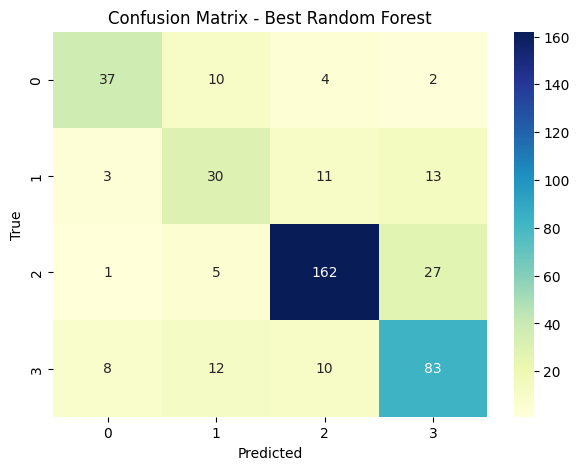

In [ ]:
# 1. CONFUSION MATRIX HEATMAP

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Best Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Confusion Matrix Analysis – Random Forest Model**

**Overall Performance:**

*Accuracy: 0.7464*

*Weighted F1-score: 0.7480*

The model demonstrates solid performance, particularly on the physiologically distinct weight categories.

**Class-level observations:**

*Class 2 (Overweight):*

Predicted with high accuracy, likely due to a large number of examples and clear physiological separation from other classes. Only a small number of misclassifications occur, mostly with adjacent classes (Class 1 and 3).

*Class 3 (Obesity):*

Well-classified, reflecting good model performance for distinct obesity cases. Some confusion exists with Class 2, which is expected for borderline overweight/obese instances.

*Class 1 (Normal weight):*

Shows notable confusion with Class 3 (Obesity) and, to a lesser extent, Class 2 (Overweight). This aligns with physiological borderline cases, where BMI values overlap between categories.

*Class 0 (Insufficient weight):*

Correctly predicted in 37 out of 52 instances (~71% accuracy).
Despite being a minority class, the model detects most low-weight individuals accurately, though some are misclassified as Class 1.

**Summary:**

The model performs best on the majority classes (Overweight and Obesity) and on categories that are physiologically distinct.
Misclassifications mainly occur between borderline classes (Normal vs Obesity or Overweight), which is consistent with real-world overlaps in BMI categories.
Overall, the Random Forest captures the major patterns effectively while handling minority classes reasonably well.

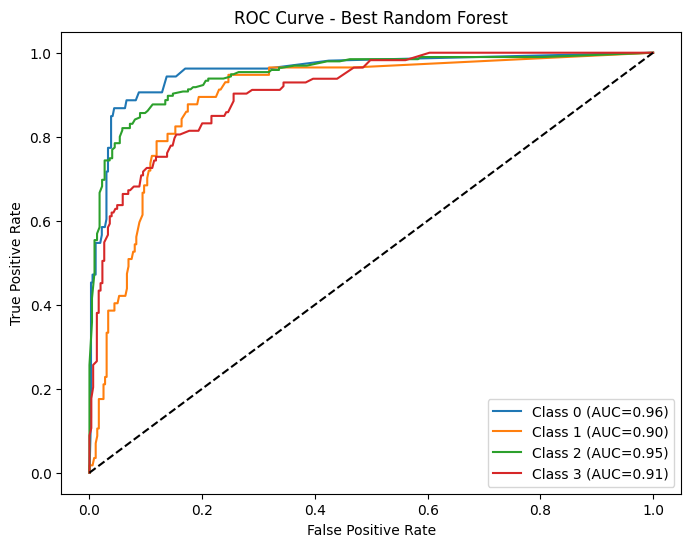

In [ ]:
# 2. ROC CURVE (MULTICLASS)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve - Best Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

**ROC Curve Analysis – Random Forest Model**

The ROC (Receiver Operating Characteristic) curves provide insight into the model’s ability to **distinguish between weight classes**. The area under the curve (AUC) for each class is as follows:

**Overall performance:**

The model exhibits excellent separability across all four classes, with AUC values consistently above 0.90.

**Class-specific insights:**

* Class 0 (Insufficient weight) and Class 2 (Overweight) show the highest AUCs (0.96 and 0.95), reflecting clear distinction from other classes.

* Class 1 (Normal weight) also performs well (AUC 0.90), though there is some overlap with adjacent classes (Class 0 and Class 2).

* Class 3 (Obesity) has a slightly lower AUC (0.91), indicating it is slightly more challenging to separate, likely due to greater heterogeneity within obese individuals and borderline cases with Class 2.

**Interpretation:**

High AUC values indicate that the model reliably ranks positive instances higher than negatives across classes.

Minor overlaps are expected in physiological categories where BMI values are near the thresholds, particularly for Normal vs. Obesity and Overweight vs. Obesity.

**Summary:**

The Random Forest model achieves strong discriminative ability across all weight categories, with particularly robust performance on the physiologically distinct classes (Insufficient weight and Overweight).
Slight challenges remain in distinguishing Class 3 (Obesity) from adjacent classes, consistent with real-world overlaps in BMI distributions.

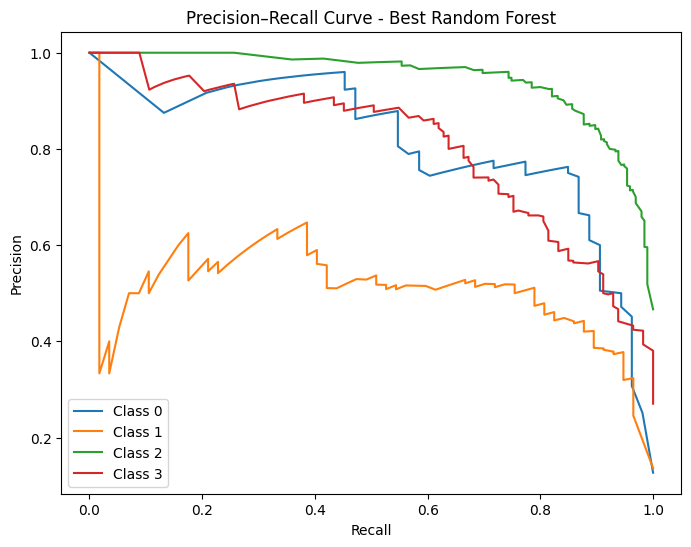

In [ ]:
# 3. PRECISION–RECALL CURVE

from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.title("Precision–Recall Curve - Best Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

**Precision–Recall Curve Analysis – Random Forest Model**

The Precision–Recall (PR) curves provide insight into the model’s ability to correctly identify positive instances for each class, especially in the presence of class imbalance.

**Observations:**

* Class 2 (Overweight):

    * Achieves near-perfect precision and recall, likely due to its large number of examples and clear separation from other categories.

    * Indicates the model reliably identifies Overweight individuals with minimal false positives or negatives.

* Class 1 (Normal weight):
    * Shows the lowest precision and recall among all classes.
    * This is expected, as Normal weight represents the central BMI category and overlaps physiologically with adjacent classes (Insufficient weight and Overweight), making it more challenging to predict.

* Classes 0 (Insufficient weight) and 3 (Obesity):
    * Both exhibit good precision and recall, indicating the model handles minority and extreme classes reasonably well.
    * Slight misclassifications occur near class boundaries, consistent with natural BMI overlaps.

**Interpretation:**

* PR curve results align with the true class distribution and the physiological distinctions of BMI categories.

* The model performs best on well-separated or high-frequency classes (Class 2), while central/borderline categories (Class 1) remain slightly more difficult to classify accurately.

**Summary:**

The Random Forest model is highly effective at detecting majority and extreme weight classes.
Challenges remain for the Normal weight class due to overlap with neighboring categories, which is consistent with real-world BMI distributions.

/tmp/ipython-input-2868279079.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


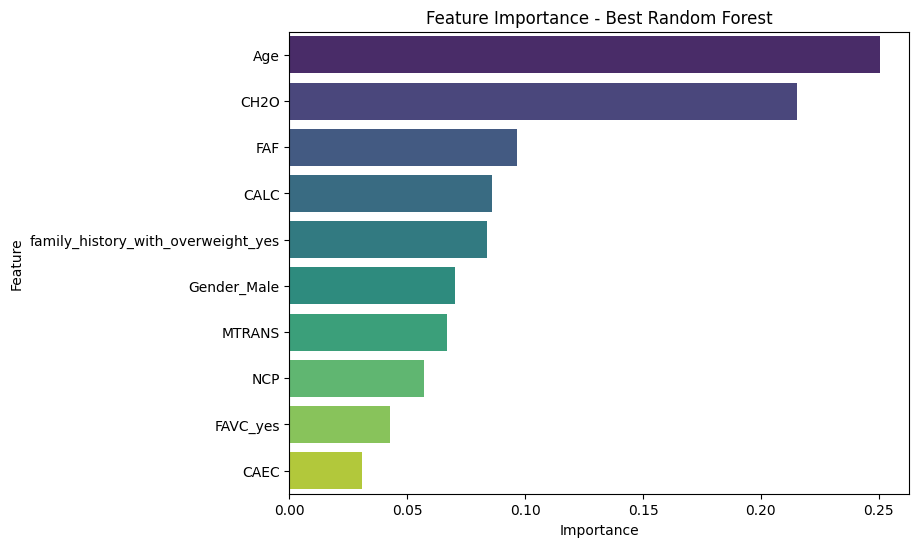

In [ ]:
# 4. FEATURE IMPORTANCE (SEABORN)

importances = rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance - Best Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

**Feature Importance Analysis – Random Forest Model**

The Random Forest model provides insight into which features contribute most to predicting weight categories. The top features are:

`Age`

Expected as a key factor, reflecting natural changes in metabolism and body composition over time.

`CH2O (Water Consumption)`

Strongly correlated with body weight, possibly reflecting overall dietary habits and hydration levels.

`FAF (Physical Activity Level)`

Captures the impact of daily activity on weight regulation, a critical behavioral factor.

`CALC (Alcohol Consumption)`

Moderate to high consumption can influence weight, providing a lifestyle-related signal.

`family_history_overweight`

Excellent genetic indicator, reflecting hereditary risk factors for overweight and obesity.

`Gender_Male`

Gender differences affect fat distribution, metabolism, and susceptibility to overweight.

`Transport (MTRANS)`

Mode of transport (e.g., walking vs. car) reflects physical activity patterns in daily life.

`NCP (Number of Daily Meals)`

Indicates eating habits, which can influence caloric intake and body weight.

**Interpretation:**

The model successfully combines biological, genetic, and behavioral factors, capturing the multidimensional nature of overweight and obesity.
Features related to lifestyle and diet (`CH2O`, `FAF`, `CALC`, `NCP`, `transport`) complement innate factors (`age`, `gender`, `family history`), enabling robust predictions across classes.

**Summary:**

Random Forest effectively identifies and leverages key predictors of weight categories. Both physiological and behavioral features are represented, reflecting real-world determinants of overweight and obesity.

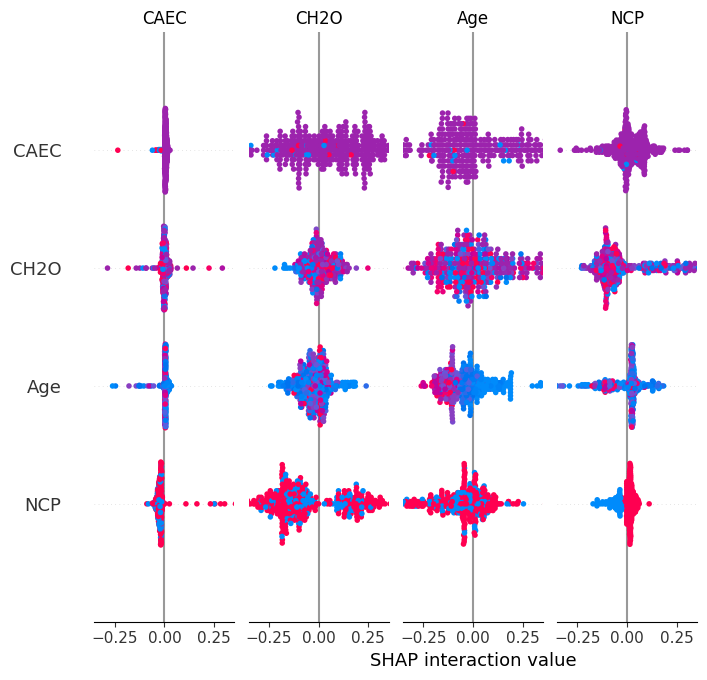

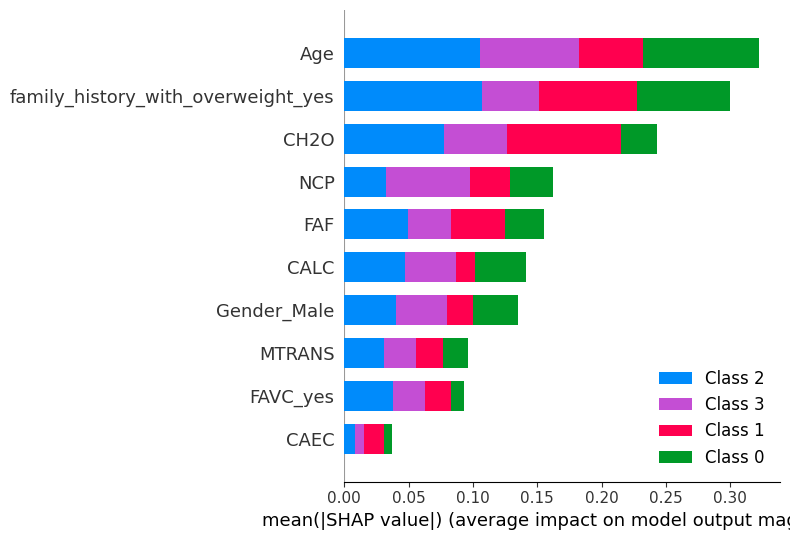

In [ ]:
# 5. SHAP VALUES (GLOBAL EXPLAINABILITY)

import shap

explainer = shap.TreeExplainer(rf.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_test, plot_type="dot")

# Global importance bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


**Insights from SHAP Values**

***Age as a Key Driver***

Higher age consistently increases the probability of being classified as Overweight (Class 2) or Obese (Class 3).

This aligns with physiological trends, as older individuals often have higher body fat accumulation.

SHAP shows both global importance and individual-level contributions, confirming its relevance across most samples.

***Water Consumption (CH2O) Effects***

Lower water intake pushes predictions toward Obesity (Class 3).

This suggests a potential behavioral marker: insufficient hydration correlates with higher BMI categories in this dataset.

***Physical Activity (FAF) Influence***

Higher activity levels increase the likelihood of being classified as Normal weight (Class 1).

SHAP highlights how lifestyle factors directly contribute to healthier weight predictions.

***Family History as a Genetic Factor***

Positive family history strongly shifts predictions toward Overweight and Obesity (Classes 2–3).

Indicates that genetic predisposition is a dominant predictor for higher BMI categories.

***Consistency with Feature Importance***

SHAP confirms that the same features identified by the Random Forest’s feature importance are also the ones driving predictions.

Provides both interpretability and confidence that the model is learning meaningful patterns rather than spurious correlations.

***Actionable Interpretations***

Interventions targeting hydration, physical activity, and awareness of genetic risk could be informed by these patterns.
SHAP can also be used at an individual level to explain why a particular person is predicted as Overweight or Obese, which is useful for personalized recommendations.

# Download the model

In [ ]:
import os
import joblib

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(rf, os.path.join(save_dir, "random_forest_best_model.pkl"))
print("Model saved in:", os.path.join(save_dir, "random_forest_best_model.pkl"))

from google.colab import files

files.download("saved_models/random_forest_best_model.pkl")

Model saved in: saved_models/random_forest_best_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>